# DEEP LEARNING: AUTO-ENCODER

I want to express my greatest thanks to this open-source [link](https://blog.keras.io/building-autoencoders-in-keras.html) provided by Keras. This notebook is a direct replica of the content of their blog and it is not-for-profit only.

### What is Autoencoder?

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.


![image](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

### Are they good at data compression?

Usually, not really. In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: you can only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data. But future advances might change this, who knows.

### What are autoencoders good for?

They are rarely used in practical applications. In 2012 they briefly found an application in greedy layer-wise pretraining for deep convolutional neural networks [1], but this quickly fell out of fashion as we started realizing that better random weight initialization schemes were sufficient for training deep networks from scratch. In 2014, batch normalization [2] started allowing for even deeper networks, and from late 2015 we could train arbitrarily deep networks from scratch using residual learning [3].

Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on [Github](https://github.com/kylemcdonald/Parametric-t-SNE/blob/master/Parametric%20t-SNE%20(Keras).ipynb). Otherwise [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) also has a simple and practical implementation.

### So what's the big deal with autoencoders?

Their main claim to fame comes from being featured in many introductory machine learning classes available online. As a result, a lot of newcomers to the field absolutely love autoencoders and can't get enough of them. This is the reason why this tutorial exists!

Otherwise, one reason why they have attracted so much research and attention is because they have long been thought to be a potential avenue for solving the problem of unsupervised learning, i.e. the learning of useful representations without the need for labels. Then again, autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data. In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here. At this point there is significant evidence that focusing on the reconstruction of a picture at the pixel level, for instance, is not conductive to learning interesting, abstract features of the kind that label-supervized learning induces (where targets are fairly abstract concepts "invented" by humans such as "dog", "car"...). In fact, one may argue that the best features in this regard are those that are the worst at exact input reconstruction while achieving high performance on the main task that you are interested in (classification, localization, etc).

In self-supervized learning applied to vision, a potentially fruitful alternative to autoencoder-style input reconstruction is the use of toy tasks such as jigsaw puzzle solving, or detail-context matching (being able to match high-resolution but small patches of pictures with low-resolution versions of the pictures they are extracted from). The following paper investigates jigsaw puzzle solving and makes for a very interesting read: Noroozi and Favaro (2016) [Unsupervised Learning of Visual Representations by Solving Jigsaw Puzzles](http://arxiv.org/abs/1603.09246). Such tasks are providing the model with built-in assumptions about the input data which are missing in traditional autoencoders, such as "visual macro-structure matters more than pixel-level details".

![image](https://blog.keras.io/img/ae/jigsaw-puzzle.png)

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.
/usr/local/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

In [3]:
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

Let's also create a separate encoder model:

In [4]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [5]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [6]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [8]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [10]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.3386 - val_loss: 0.2653
Epoch 2/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.2575 - val_loss: 0.2450
Epoch 3/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.2300 - val_loss: 0.2154
Epoch 4/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.2058 - val_loss: 0.1960
Epoch 5/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.1913 - val_loss: 0.1847
Epoch 6/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.1811 - val_loss: 0.1756
Epoch 7/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.1731 - val_loss: 0.1684
Epoch 8/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.1671 - val_loss: 0.1633
Epoch 9/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.1614 - val_loss: 0.1575
Epo

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [11]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

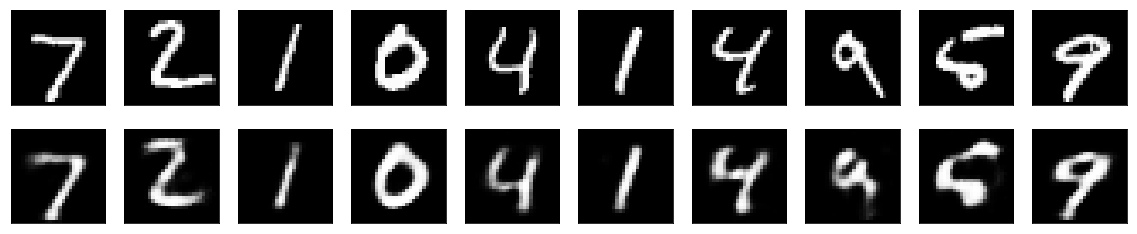

In [12]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Investigation ends here.